In [2]:
import torch
from torch import nn
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 2.5]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NN(nn.Module):
    def __init__(self, d):
        super(NN, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(1, d),
            nn.Tanh(),
            nn.Linear(d, d),
            nn.Tanh(),
            nn.Linear(d, d),
            nn.Tanh(),
            nn.Linear(d, d),
            nn.Tanh(),
            nn.Linear(d, 1)
        )

    def forward(self, x):
        return self.stack(x)

def train(model, N, a, b, epochs, loss, optimizer, show_stats=False):
    X = torch.linspace(a, b, N, requires_grad=True).reshape(N, 1)

    for e in range(0, epochs):
        optimizer.zero_grad()
        output = model(X)

        total_loss = 0
        for coef, fn in loss:
            total_loss += coef*fn(X, output)

        total_loss.backward()
        optimizer.step()

        if show_stats: 
            if e % (epochs/8) == 0:
                    print(f"Epoch: {e}\t Total Loss: {total_loss}")

def dx(f, wrt, n):
    f = torch.sum(f)
    for i in range(n):
        grads = torch.autograd.grad(f, wrt, create_graph=True)[0]
        f = grads.sum()
    return grads

Using cpu device


In [3]:
# Loss functions


# y' = e^x; y(0) = 1
loss_a = [[None, lambda x, y: torch.linalg.norm(dx(y, x, 1) - torch.exp(x), ord=2)],
          [None, lambda x, y: torch.linalg.norm(y[0] - 1, ord=2)]]
fn_a = lambda x: torch.exp(x)

# y' = x; y(0) = 1 ... k = 1; alph = 30
loss_b = [[None, lambda x, y: torch.linalg.norm(dx(y, x, 1) - x, ord=2)],
          [None, lambda x, y: torch.linalg.norm(y[0] - 1, ord=2)]]
fn_b = lambda x: (1/2)*(x**2 + 2)

# 5y' - 4y^2 = 0; y(0) = -8
loss_c = [[None, lambda x, y: torch.linalg.norm(5*dx(y, x, 1) - 4*y**2, ord=2)],
          [None, lambda x, y: torch.linalg.norm(y[0] + 8, ord=2)]]
fn_c = lambda x: -40/(32*x + 5)

# 10y''+ 5y = 0; y(0) = 0; y'(0) = 1 ... k = 1; alph = 1; beta = 5000
loss_d = [[None, lambda x, y: torch.linalg.norm(10*dx(y, x, 2) + 5*y, ord=2)],
          [None, lambda x, y: torch.linalg.norm(y[0], ord=2)],
          [None, lambda x, y: torch.linalg.norm(dx(y[0], x, 1) - 1, ord=2)]]
fn_d = lambda x: torch.sqrt(2)*torch.sin(x/torch.sqrt(2))


optimal beta: 2.0


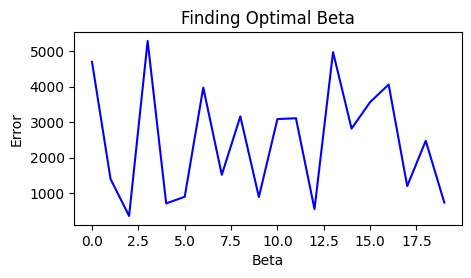

In [5]:
# Finding optimal beta value for first order ODEs


loss = loss_a.copy()
loss[0][0] = 1 # Set alpha to 1

a = 0
b = 5
N = 50
epochs = 10000

# Test x points
x = torch.linspace(a, b, 1000).reshape(1000, 1)

betas = np.arange(0, 20, 1)
stats = []

for beta in betas:

    # Adjust the loss function
    loss[1][0] = beta
    
    # Train the model 
    model = NN(20)
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    train(model, N, a, b, epochs, loss, optimizer, show_stats=False)

    # Calculate the error
    y = fn_a(x.reshape(1000, 1))
    y_hat = model(x.reshape(1000, 1)).detach()
    error = float(torch.mean((y - y_hat)**2))
    stats.append([error, beta])

stats = np.asarray(stats)
min_index = np.argmin(stats[:, 0], axis=0)
opt_beta = stats[:, 1][min_index]
loss[0][0] = 1
loss[1][0] = opt_beta

print(f"optimal beta: {opt_beta}")
plt.plot(stats[:, 1], stats[:, 0], 'b')
plt.title("Finding Optimal Beta")
plt.ylabel("Error")
plt.xlabel("Beta")
plt.show()

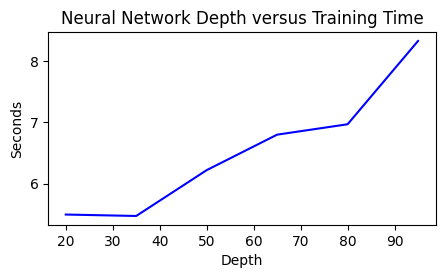

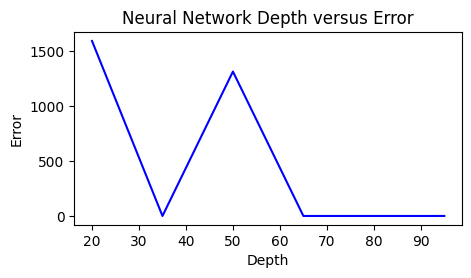

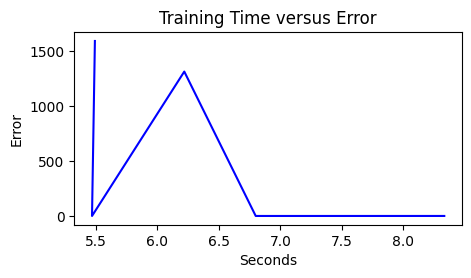

In [6]:
# Finding optimal depth value for first order ODEs


a = 0
b = 5
N = 50
epochs = 10000


depths = np.arange(20, 100, 15)
stats = []
for depth in depths:
    
    # Create the  model and train
    model = NN(depth)
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)

    start_time = time.time()
    train(model, N, a, b, epochs, loss, optimizer, show_stats=False)
    train_time = time.time() - start_time

    # Calculate the stats
    y = fn_a(x.reshape(1000, 1))
    y_hat = model(x.reshape(1000, 1)).detach()
    error = float(torch.mean((y - y_hat)**2))
    stats.append([error, train_time, depth])

stats = np.asarray(stats)

plt.figure(1)
plt.plot(stats[:, 2], stats[:, 1], color='b')
plt.title("Neural Network Depth versus Training Time")
plt.ylabel("Seconds")
plt.xlabel("Depth")

plt.figure(2)
plt.plot(stats[:, 2], stats[:, 0], color='b')
plt.title("Neural Network Depth versus Error")
plt.ylabel("Error")
plt.xlabel("Depth")

plt.figure(3)
plt.plot(stats[:, 1], stats[:, 0], color='b')
plt.title("Training Time versus Error")
plt.ylabel("Error")
plt.xlabel("Seconds")

plt.show()

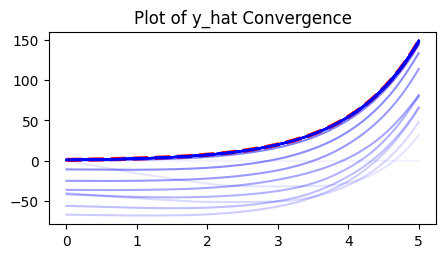

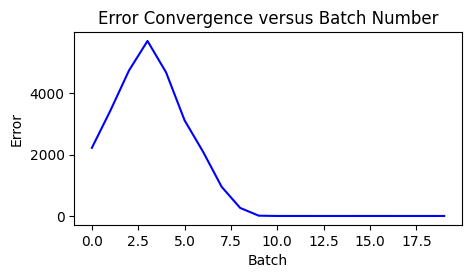

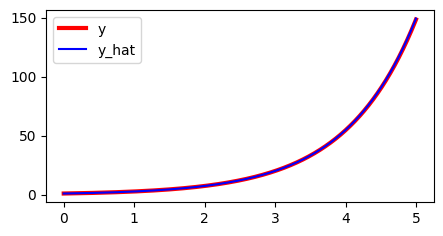

In [7]:
model = NN(35)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

batch_count = 20

y = fn_a(x)
plt.figure(1)
plt.plot(x, y, color='r', linestyle="dashed", linewidth=3)
error = []

# Train in batches
for batch in range(batch_count):

    # Calculate Error
    y_hat = model(x).detach()
    plt.plot(x, y_hat, color='b', alpha=(batch + 1)/batch_count)
    error.append(float(torch.mean((y - y_hat)**2)))


    # Train the model
    train(model, 200, 0, 5, 750, loss, optimizer, show_stats=False)

plt.title("Plot of y_hat Convergence")
plt.show()


plt.figure(2)
plt.plot(error, color='b')
plt.title("Error Convergence versus Batch Number")
plt.xlabel("Batch")
plt.ylabel("Error")

plt.figure(3)
y = fn_a(x)
y_hat = model(x).detach()
plt.plot(x, y, color='r', lw=3, label="y")
plt.plot(x, y_hat, color='b', label="y_hat")
plt.legend()
plt.show()

In [1]:
import pygame

pygame.init()
window = pygame.display.set_mode([800,600],pygame.RESIZABLE)
clock = pygame.time.Clock()
game_running = True 


x = 0
while game_running :
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            print("closing the game")
            game_running = False
            break
    window.fill((0, 0, 0))
    # print(model(torch.Tensor([x])).item())
    # pygame.draw.circle(window, (255, 255, 255), (500 + 100*model(torch.Tensor([x])).item(), 100), 10)
    pygame.display.update()
    x+=.001


pygame.quit()

pygame 2.1.2 (SDL 2.0.18, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
closing the game


: 